<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/2D_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Convolutional Neural Network + Long Short Term Memory**
######*I am using a Convolution Neural Network (CNN) + Long Short Term Memory (LSTM) Network to find general representation while utilizing the Spatial-temporal aspect of the videos.*

In [1]:
# required libraries
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from PIL import Image
%matplotlib inline
# https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/

In [2]:
# set Numpy, Python, and Tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# mount dataset from google drive
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
os.getcwd()

Mounted at /content/gdrive/


'/content/gdrive/My Drive/247'

In [4]:
# frame dimention
IMAGE_HEIGHT, IMAGE_WIDTH = 150, 150
# frame number for each video (depth)
SEQUENCE_LENGTH = 16
# video dir path
DATASET_DIR = gdrive_path + 'Cropped_videos'
# labels of classes
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [5]:
# image cropping
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [6]:
# https://medium.com/analytics-vidhya/video-preprocessor-and-augmentation-for-deep-learning-tasks-12dd3fcce868
def load_video(path, resize=(150, 150)):
    video_reader = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            black_frame = frame
            frames.append(frame)
    finally:
        video_reader.release()
    return np.array(frames) / 255.0


In [7]:
def create_dataset(state):
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name} {state}')
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # create testing data
            if state == 'test':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'L':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create validation data
            elif state == 'valid':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'R':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create training data
            else:
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                if mouse_number != 4:
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# 6 mice for training, 2 mice for test and validation (one wound on each mice for test one for validation)
features_train, labels_train, video_files_paths_train = create_dataset('train')
features_test, labels_test, video_files_paths_test = create_dataset('test')
features_valid, labels_valid, video_files_paths_valid = create_dataset('valid')

Extracting Data of Class: hemostasis train
Extracting Data of Class: inflammatory train
Extracting Data of Class: proliferative train
Extracting Data of Class: maturation train
Extracting Data of Class: hemostasis test
Extracting Data of Class: inflammatory test
Extracting Data of Class: proliferative test
Extracting Data of Class: maturation test
Extracting Data of Class: hemostasis valid
Extracting Data of Class: inflammatory valid
Extracting Data of Class: proliferative valid
Extracting Data of Class: maturation valid


In [9]:
# one_hot_encoded_labels
labels_train = keras.utils.to_categorical(labels_train)
labels_test = keras.utils.to_categorical(labels_test)
labels_valid = keras.utils.to_categorical(labels_valid)

In [10]:
def create_convlstm_model():
    # A Sequential model for model construction
    model = tf.keras.Sequential()

    # Model Architecture.
    ############################################################################
    model.add(tf.keras.layers.ConvLSTM2D(filters = 4,
                                         kernel_size = (3, 3),
                                         activation = 'tanh',
                                         data_format = "channels_last",
                                         recurrent_dropout = 0.2,
                                         return_sequences = True,
                                         input_shape = (SEQUENCE_LENGTH,
                                                        IMAGE_HEIGHT,
                                                        IMAGE_WIDTH, 3)))
    
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2),
                                           padding='same',
                                           data_format='channels_last'))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
    
    model.add(tf.keras.layers.ConvLSTM2D(filters = 8,
                                         kernel_size = (3, 3),
                                         activation = 'tanh',
                                         data_format = "channels_last",
                                         recurrent_dropout=0.2,
                                         return_sequences=True))
    
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2),
                                           padding='same',
                                           data_format='channels_last'))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
    
    model.add(tf.keras.layers.ConvLSTM2D(filters = 14,
                                         kernel_size = (3, 3),
                                         activation = 'tanh',
                                         data_format = "channels_last",
                                         recurrent_dropout=0.2,
                                         return_sequences=True))
    
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2),
                                           padding='same',
                                           data_format='channels_last'))
    
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))
    
    model.add(tf.keras.layers.ConvLSTM2D(filters = 16,
                                         kernel_size = (3, 3),
                                         activation = 'tanh',
                                         data_format = "channels_last",
                                         recurrent_dropout=0.2,
                                         return_sequences=True))
    
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2),
                                           padding='same',
                                           data_format='channels_last'))
    
    model.add(tf.keras.layers.Flatten()) 
    
    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))
    ############################################################################
    # Display the models summary.
    model.summary()
    # Return the constructed convlstm model.
    return model

In [11]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 16, 148, 148, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 74, 74, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 16, 74, 74, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 72, 72, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 16, 36, 36, 8)    0         
 3D)                                                             
                                                        

In [12]:
# keras.utils.plot_model(convlstm_model,
#                          to_file = 'convlstm_model_structure_plot.png',
#                          show_shapes = True,
#                          show_layer_names = True)

In [13]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                        patience = 10,
                                                        mode = 'min',
                                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy',
                       optimizer = 'Adam',
                       metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train,
                                                     y = labels_train,
                                                     epochs = 50,
                                                     batch_size = 4,
                                                     shuffle = True,
                                                     validation_data = (features_valid, labels_valid),
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
404/404 [==============================] - 99s 207ms/step - loss: 0.8875 - accuracy: 0.5662 - val_loss: 0.9477 - val_accuracy: 0.5772
Epoch 2/50
404/404 [==============================] - 80s 199ms/step - loss: 0.7278 - accuracy: 0.6448 - val_loss: 0.8409 - val_accuracy: 0.6544
Epoch 3/50
404/404 [==============================] - 81s 200ms/step - loss: 0.6188 - accuracy: 0.7228 - val_loss: 0.6872 - val_accuracy: 0.7647
Epoch 4/50
404/404 [==============================] - 82s 204ms/step - loss: 0.4626 - accuracy: 0.8001 - val_loss: 0.6410 - val_accuracy: 0.8015
Epoch 5/50
404/404 [==============================] - 82s 203ms/step - loss: 0.3832 - accuracy: 0.8422 - val_loss: 0.6160 - val_accuracy: 0.7978
Epoch 6/50
404/404 [==============================] - 83s 205ms/step - loss: 0.3251 - accuracy: 0.8645 - val_loss: 0.7305 - val_accuracy: 0.7132
Epoch 7/50
404/404 [==============================] - 82s 203ms/step - loss: 0.2517 - accuracy: 0.9028 - val_loss: 0.7627 - val_ac

In [14]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

9/9 [==============================] - 3s 181ms/step - loss: 0.8861 - accuracy: 0.6912


In [15]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

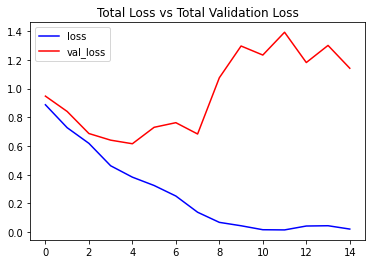

In [17]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

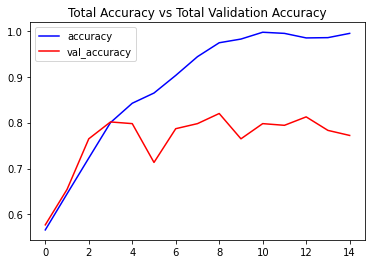

In [18]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 